In [1]:
# all time series correlation map btwn 
# SST and SIC AND OHC DUDE.

# separate seasons correlation too, maybe group every 3 months.

# run the tests of the data thru fortran code then.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import netCDF4
from netCDF4 import Dataset

import xarray as xr
import glob, os
#print(xr.__version__)
import xskillscore as xs

from scipy import stats


sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()

In [2]:
# SIC Anomaly dataset:
filename = '/d6/bxw2101/combined_netcdf_files/sic_anom_monthly_2x2.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom
#sic_anom

In [3]:
# SST Anomaly dataset:
filename = '/d6/bxw2101/combined_netcdf_files/sst_anom_monthly_2x2.nc'
sst_anom_ds = xr.open_dataset(filename)
sst_anom_ds = sst_anom_ds.rename({'X': 'x', 'Y': 'y'})
sst_anom = sst_anom_ds.sst_anom
#sst_anom

In [4]:
# OHC Anomaly dataset:
filename = '/d6/bxw2101/combined_netcdf_files/ohc_anom_monthly_2x2.nc'
ohc_anom_ds = xr.open_dataset(filename)
ohc_anom = ohc_anom_ds.ohc_anom

In [5]:
# SIT Anomaly dataset:
filename = '/d6/bxw2101/combined_netcdf_files/sit_anom_monthly_2x2.nc'
sit_anom_ds = xr.open_dataset(filename)
sit_anom = sit_anom_ds.sit_anom

In [6]:
# Get da seasonal correlations here for SIC and SST, SIC and OHC.
seasons = ["DJF", "MAM", "JJA", "SON"]
months = [2, 5, 9, 11]
# sic_szns = sic_anom.groupby("tdim.season")
# sic_months = sic_anom.groupby("tdim.")
# sst_szns = sst_anom.groupby("tdim.season")
# ohc_szns = ohc_anom.groupby("tdim.season")
# djf = sic_szns.groups['DJF']
# mam = sic_szns.groups['MAM']
# jja = sic_szns.groups['JJA']
# son = sic_szns.groups['SON']
# seasons = [djf, mam, jja, son]
#season_names = ["DJF", "MAM", "JJA", "SON"]

In [7]:
# sic_anom.mean(dim=['x', 'y']).plot()
# sst_anom.mean(dim=['x', 'y']).plot()
# ohc_anom.mean(dim=['x', 'y']).plot()
# PLOT W TWO AXES YOU DUMMY!!!

In [8]:
# This gets the significant p-values' lat and lon arrays.
def get_sig_latlons(a1, a2):
    sic_sst_pvals = xs.pearson_r_eff_p_value(a1, a2, dim='tdim', skipna=True)
    sic_sst_corr_sig = sic_sst_corr.where(sic_sst_pvals < 0.05)
    
    sig_lons = []
    sig_lats = []
    for x in sic_sst_corr_sig.x:
        for y in sic_sst_corr_sig.y:
            if not np.isnan(sic_sst_corr_sig.sel(x=x, y=y)):
                sig_lons.append(int(x.values))
                sig_lats.append(int(y.values))
    return sig_lons, sig_lats
#to scatter the significance:
# need longitude and latitude arrays. they are the same size, correspond to lon and lat pairs. ok.
# here lons and lats gotta be the same length. duh.
# https://xarray.pydata.org/en/stable/generated/xarray.plot.scatter.html

In [9]:
# We use this after declaring a figure and axes to plot only the significant correlation coefficients.
def plot_sig(da1, da2, vmin, vmax, c):
    #ax = plt.axes(projection=sp)
    corrs_da = xr.corr(da1, da2, dim='tdim')
    pvals_da = xs.pearson_r_eff_p_value(da1, da2, dim='tdim', skipna=True)
    sig_corrs_da = corrs_da.where(pvals_da < 0.05)
    im = sig_corrs_da.plot(transform=pc, vmin = vmin, vmax = vmax, cmap='plasma', add_colorbar = c) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    return im

In [21]:
# Seasonal plots
def seasonal_plots(da1, da2, da1name, da2name, vmin, vmax):
    for s_i in range(len(seasons)):
        season = seasons[s_i]
        ax = plt.subplot(2, 2, s_i + 1, projection=sp)
        corrs_da = xr.corr(da1.sel(tdim=da1.tdim.dt.season==season),
                           da2.sel(tdim=da2.tdim.dt.season==season),
                           dim='tdim')
        pvals_da = xs.pearson_r_eff_p_value(da1.sel(tdim=da1.tdim.dt.season==season),
                                            da2.sel(tdim=da2.tdim.dt.season==season),
                                            dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
        im = sig_corrs_da.plot(transform=pc, vmin = vmin, vmax = vmax, cmap='plasma', add_colorbar = False) 
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        plt.title(seasons[s_i], fontsize=20)
    plt.suptitle("Seasonal correlation map btwn " + da1name + " and " + da2name, fontsize=30)
    return im

In [11]:
# Monthly plots
def monthly_plots(da1, da2, da1name, da2name, vmin, vmax):
    for m_i in range(len(months)):
        m = months[m_i]
        ax = plt.subplot(2, 2, m_i + 1, projection=sp)
        corrs_da = xr.corr(da1.sel(tdim=da1.tdim.dt.month==m),
                           da2.sel(tdim=da2.tdim.dt.month==m),
                           dim='tdim')
        pvals_da = xs.pearson_r_eff_p_value(da1.sel(tdim=da1.tdim.dt.month==m),
                                            da2.sel(tdim=da2.tdim.dt.month==m),
                                            dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
        im = sig_corrs_da.plot(transform=pc, vmin = vmin, vmax = vmax, cmap='plasma', add_colorbar = False) 
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        plt.title(m)
    plt.suptitle("CORRELATION MAP btwn " + da1name + " and " + da2name + ", Monthly")
    return im

In [12]:
# Lagged plots
def lagged_plots(da1, da2, da1name, da2name, vmin, vmax):
    for lag in range(12):
        ax = plt.subplot(3, 4, lag + 1, projection=sp)
        corrs_da = xr.corr(da1.shift(tdim=-lag), da2, dim='tdim')
        pvals_da = xs.pearson_r_eff_p_value(da1.shift(tdim=-lag), da2, dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
    
        im = sig_corrs_da.plot(transform=pc, vmin = vmin, vmax = (vmax + 0.2), cmap='plasma', add_colorbar=False)
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        plt.title(lag)
    return im
    #SOMETHING BOUT PLT.SUPTITLE HERE????

In [13]:
def single_point_lag(da1, da2, da1name, da2name, lat1, lon1):
    arb_anom = da1.sel(tdim='2017-11-01').where((da1.y==lat1) & (da1.x == lon1))
    
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes(projection=sp)
    arb_anom.plot(transform=pc, vmin=-1, vmax=0.2, cmap='plasma')
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    
    p_da1 = da1.sel(y=lat1, x=lon1)
    p_da2 = da2.sel(y=lat1, x=lon1)

    lag_corrs = np.zeros(20)
    for i in range(len(lag_corrs)):
        lag = i
        lag_corr = xr.corr(p_da1.shift(tdim=-lag), p_da2, dim="tdim")
        lag_corrs[lag] = lag_corr
        #print(lag_corr.values)
        #non_xr_lag_corr = stats.pearsonr(np.nan_to_num(sic_anom_chop.values), np.nan_to_num(sst1.values))
        # This pearsonr function ALSO gets the p values. print them to see.
        #print(non_xr_lag_corr)

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.arange(0, len(lag_corrs)), lag_corrs)
    plt.ylabel('Magnitude of pearson correlation coefficient')
    plt.xlabel(da2name + ' Lead/ ' + da1name + ' Lag time, in months')
    plt.title('Point @ lat = ' + str(lat1) + ', lon = '+ str(lon1))
    plt.xticks(np.arange(0, len(lag_corrs)));
    

In [14]:
def double_lag_plot(comp_da, comp_da_name):
    sic_lag_corrs = np.zeros(20)
    sit_lag_corrs = np.zeros(20)
    for i in range(len(sic_lag_corrs)):
        lag = i
        lag_corr_da = xr.corr(sic_anom.shift(tdim=-lag), comp_da, dim="tdim")
        sic_lag_corrs[lag] = lag_corr_da.mean()
        lag_corr_da = xr.corr(sit_anom.shift(tdim=-lag), comp_da, dim="tdim")
        sit_lag_corrs[lag] = lag_corr_da.mean()
        #print(lag_corr.values)
        #non_xr_lag_corr = stats.pearsonr(np.nan_to_num(sic_anom_chop.values), np.nan_to_num(sst1.values))
        # This pearsonr function ALSO gets the p values. print them to see.
        #print(non_xr_lag_corr)

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.arange(0, len(sic_lag_corrs)), sic_lag_corrs)
    plt.plot(np.arange(0, len(sit_lag_corrs)), sit_lag_corrs)
    plt.legend(["SIC", "SIT"])
    plt.ylabel('Pearson Corr')
    plt.xlabel(comp_da_name + ' Lead/ Sea Ice Lag time, in months')
    plt.title('Average Correlation - Lag Plot: SIC/SIT vs. ' + comp_da_name)
    plt.xticks(np.arange(0, len(sic_lag_corrs)));
    

In [15]:
def all_points_lag(da1, da2, da1name, da2name):
    lag_corrs = np.zeros(20)
    for i in range(len(lag_corrs)):
        lag = i
        lag_corr_da = xr.corr(da1.shift(tdim=-lag), da2, dim="tdim")
        lag_corrs[lag] = lag_corr_da.mean()
        #print(lag_corr.values)
        #non_xr_lag_corr = stats.pearsonr(np.nan_to_num(sic_anom_chop.values), np.nan_to_num(sst1.values))
        # This pearsonr function ALSO gets the p values. print them to see.
        #print(non_xr_lag_corr)

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.arange(0, len(lag_corrs)), lag_corrs)
    plt.ylabel('Magnitude of pearson correlation coefficient')
    plt.xlabel(da2name + ' Lead/ ' + da1name + ' Lag time, in months')
    plt.title('Averaged over all points correlation')
    plt.xticks(np.arange(0, len(lag_corrs)));
    

In [16]:
# PUTTING IT ALL TOGETHER
def all_corr_plots(da1, da2, da1name, da2name, vmin, vmax, lat1, lon1):
    fig = plt.figure(figsize=(10,7))
    ax = plt.axes(projection=sp)
    plot_sig(da1, da2, vmin, vmax, True)
    plt.title("Statistically significant correlation coeffs btwn " + da1name + " and " + da2name);
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    plt.show()
    
    fig = plt.figure(figsize=(16, 12))
    im = seasonal_plots(da1, da2, da1name, da2name, vmin, vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax = cbar_ax)
    
    fig = plt.figure(figsize=(16, 12))
    im = monthly_plots(da1, da2, da1name, da2name, vmin, vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax = cbar_ax)
    
    
    fig = plt.figure(figsize=(20, 15))
    im = lagged_plots(da1, da2, da1name, da2name, vmin, vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax = cbar_ax)
    
    
    single_point_lag(da1, da2, da1name, da2name, lat1, lon1)
    
    all_points_lag(da1, da2, da1name, da2name)

# SIC and SST Correlation Maps

### Entire time series:

Text(0.5, 1.0, 'CORRELATION MAP btwn SIC and SST!')

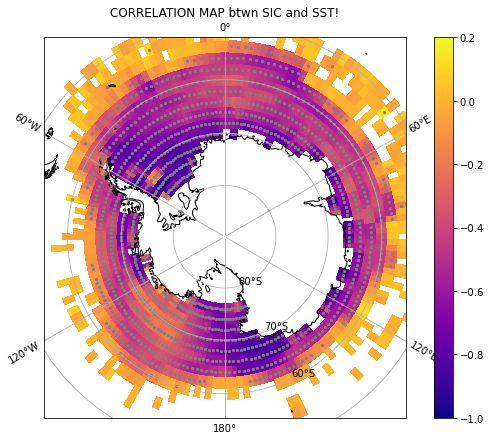

In [16]:
# This will now be an obsolete way to plot the statistical significance.

sic_sst_corr = xr.corr(sic_anom, sst_anom, dim='tdim')
sig_lons, sig_lats = get_sig_latlons(sic_anom, sst_anom)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
sic_sst_corr.plot(transform=pc, vmin = -1, vmax = .2, cmap='plasma') #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.scatter(sig_lons, sig_lats, transform=pc, s=5, c="grey")
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('CORRELATION MAP btwn SIC and SST!')

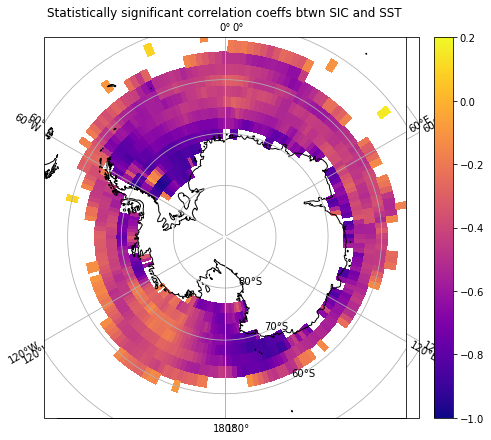

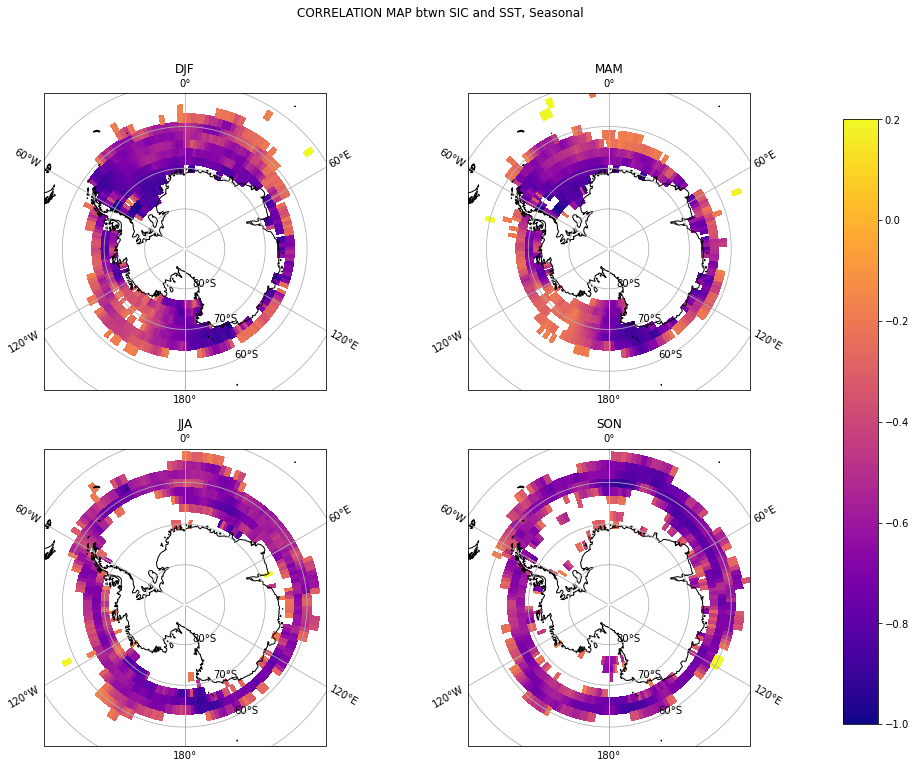

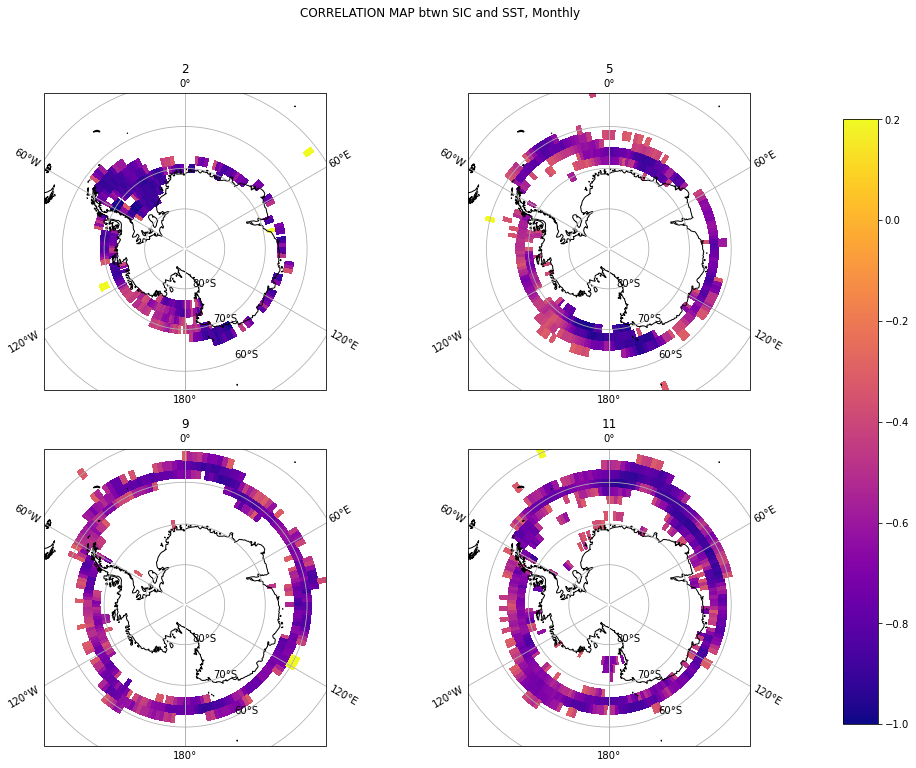

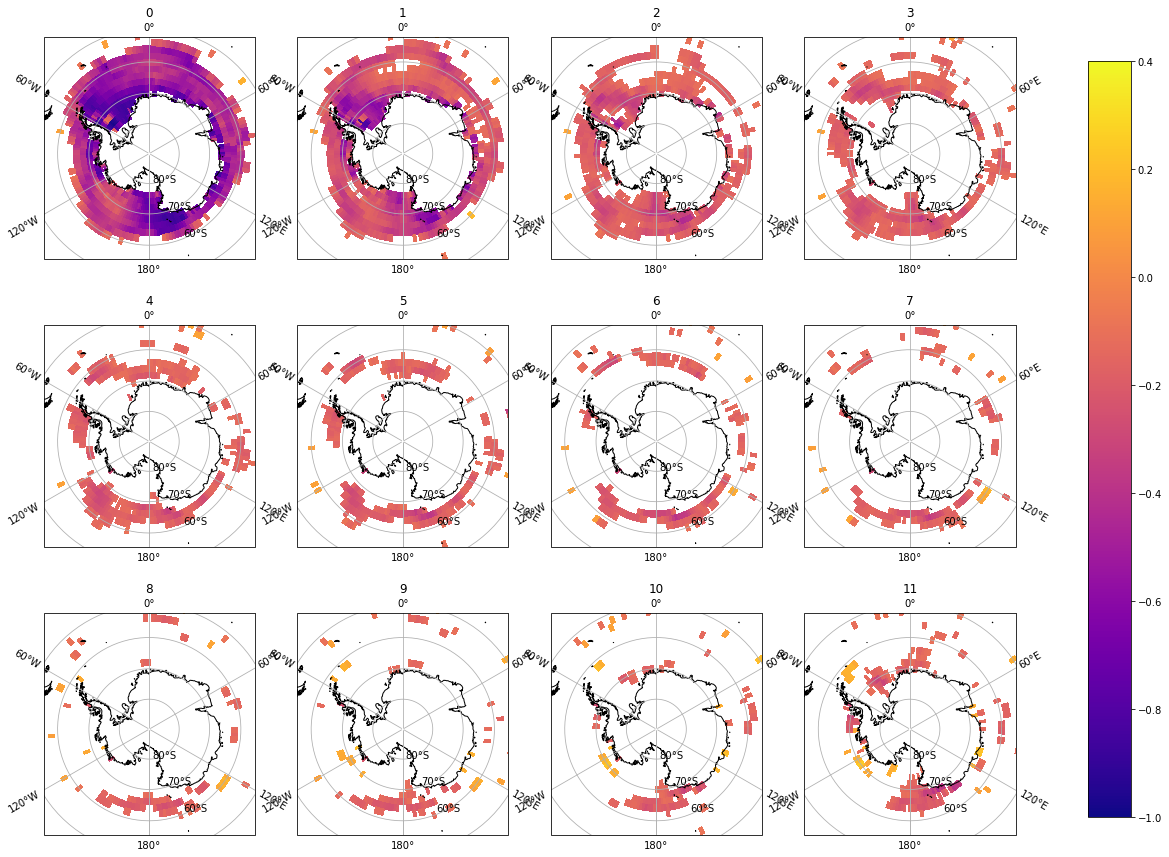

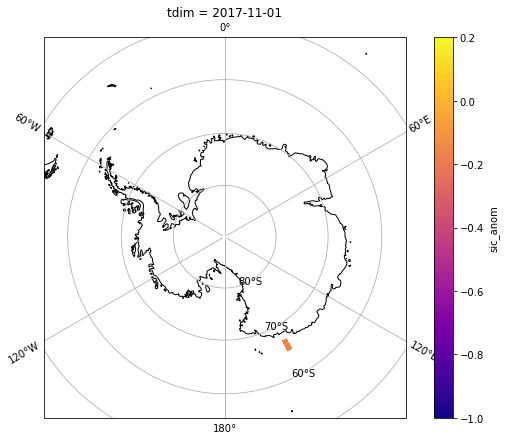

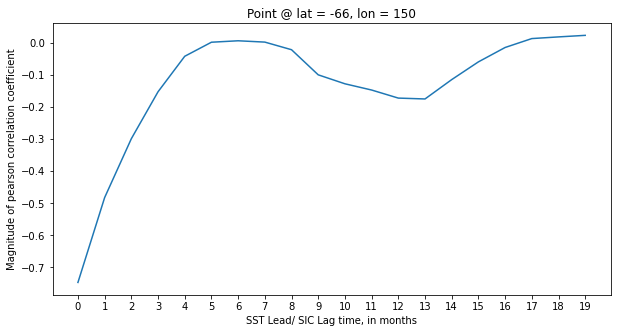

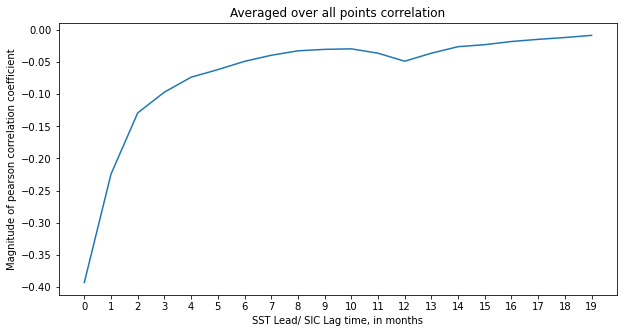

In [17]:
all_corr_plots(sic_anom, sst_anom, "SIC", "SST", -1, 0.2, -66, 150)

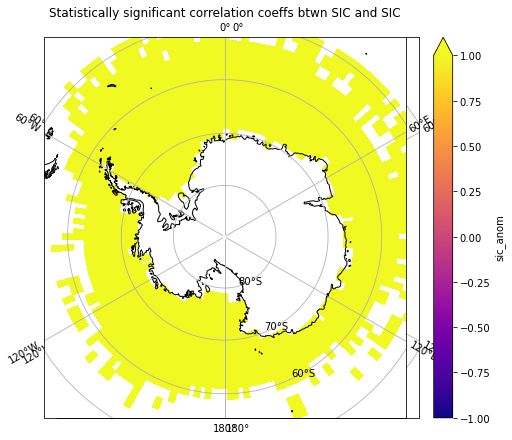

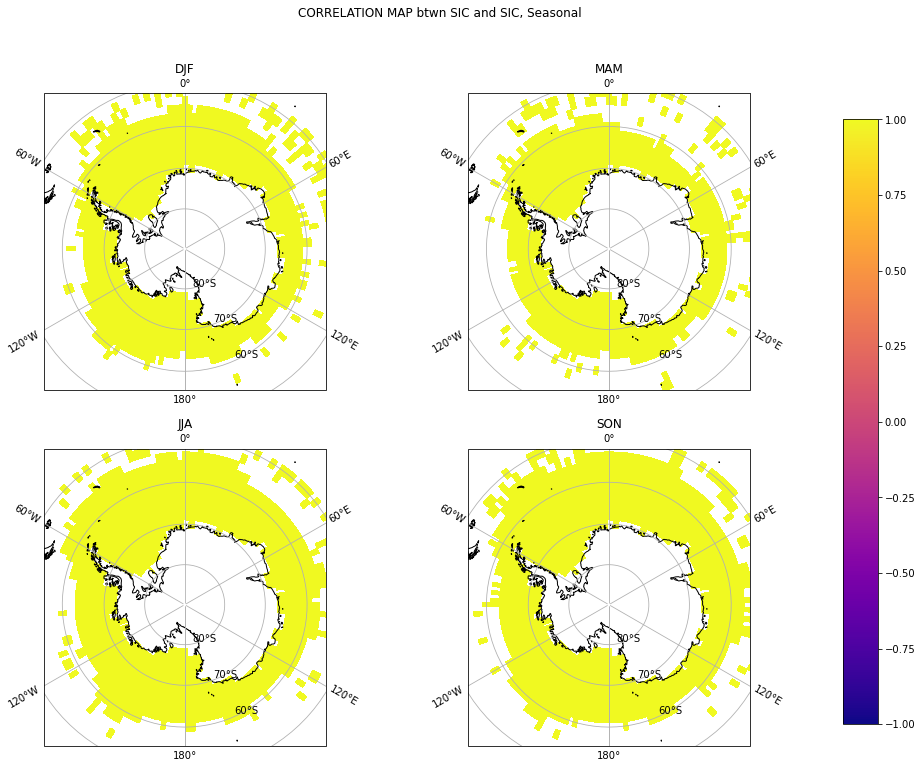

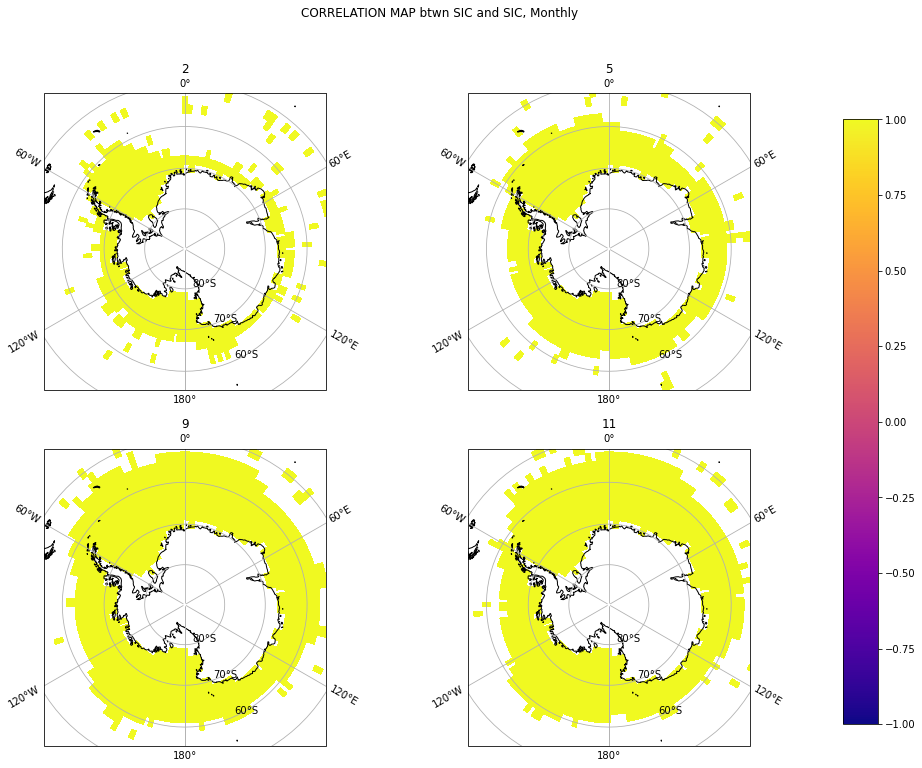

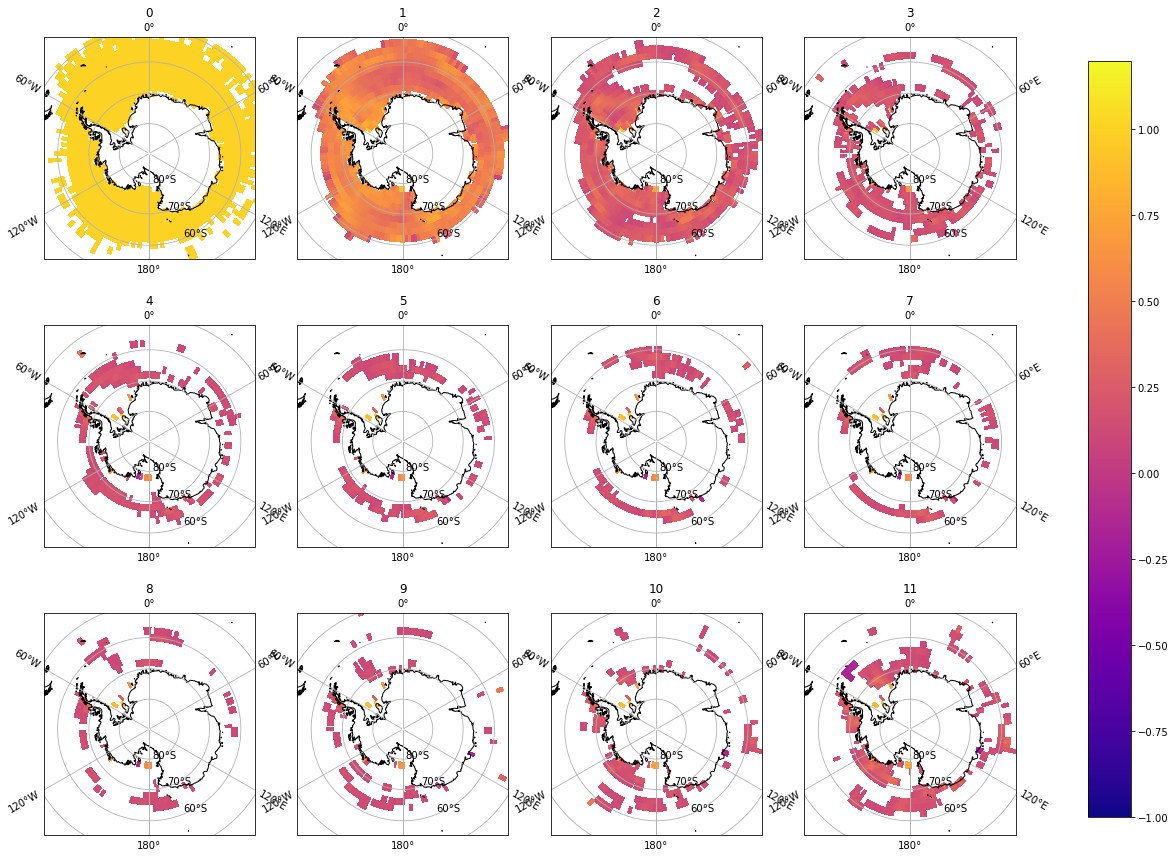

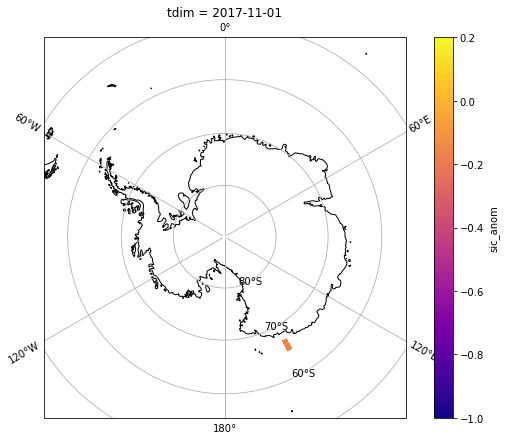

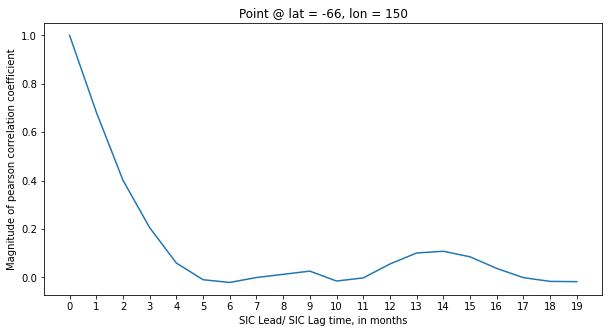

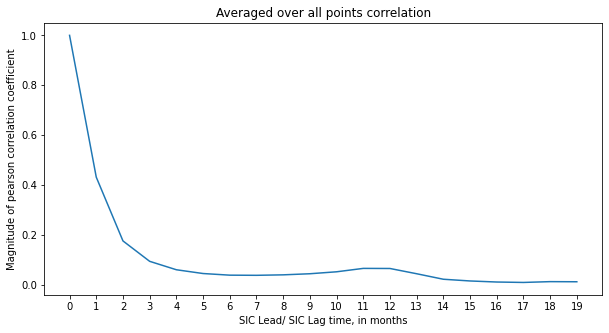

In [19]:
# just testing
all_corr_plots(sic_anom, sic_anom, "SIC", "SIC", -1, 1, -66, 150)

# SIC and OHC Correlation Maps

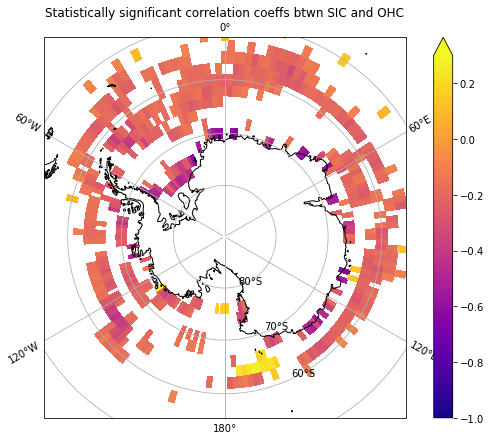

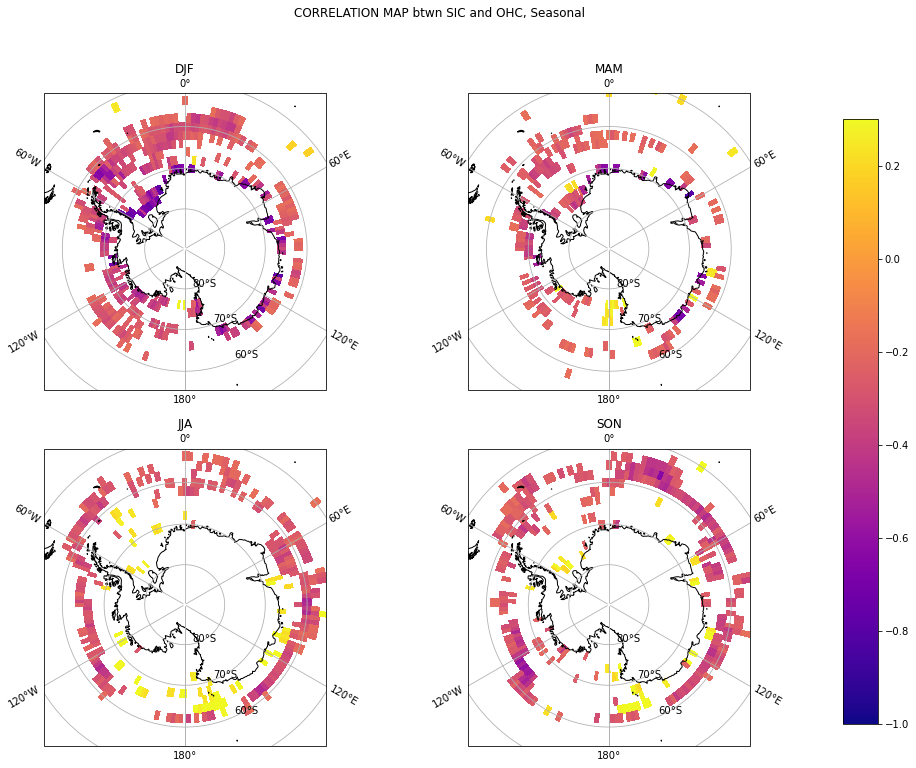

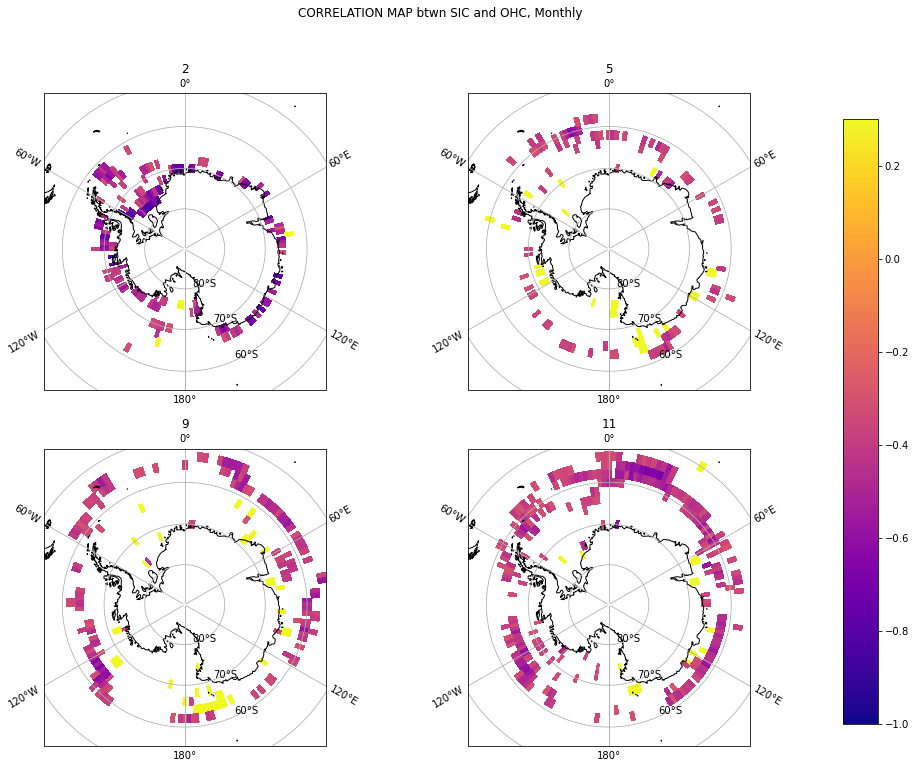

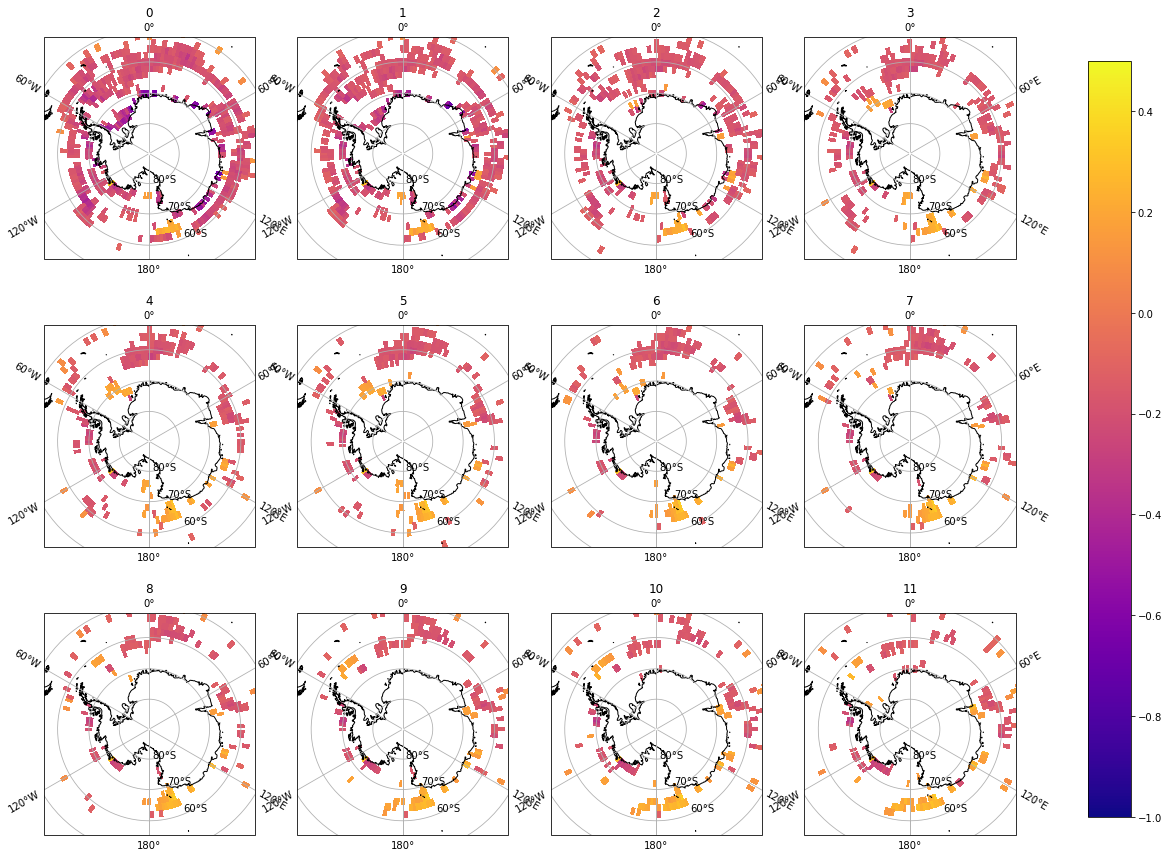

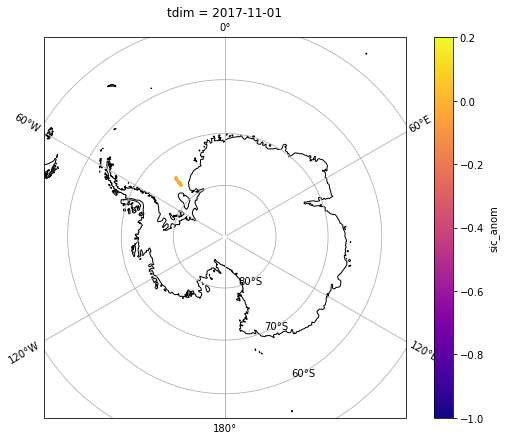

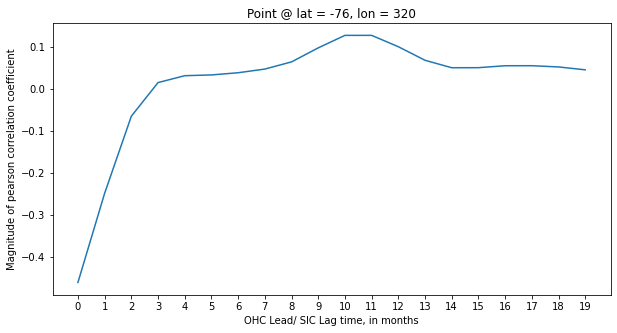

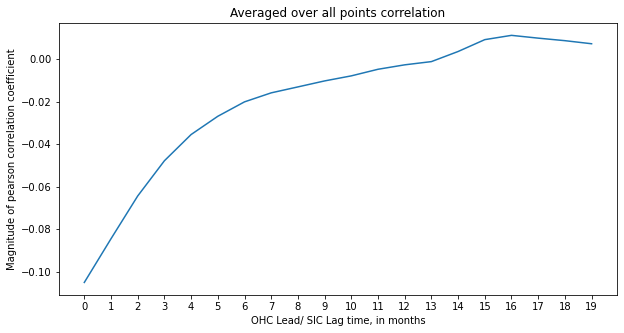

In [19]:
all_corr_plots(sic_anom, ohc_anom, "SIC", "OHC", -1, 0.3, -76, 320)

# SIT and OHC Comparisons

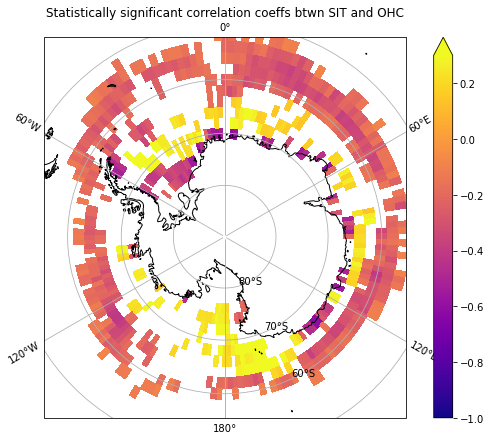

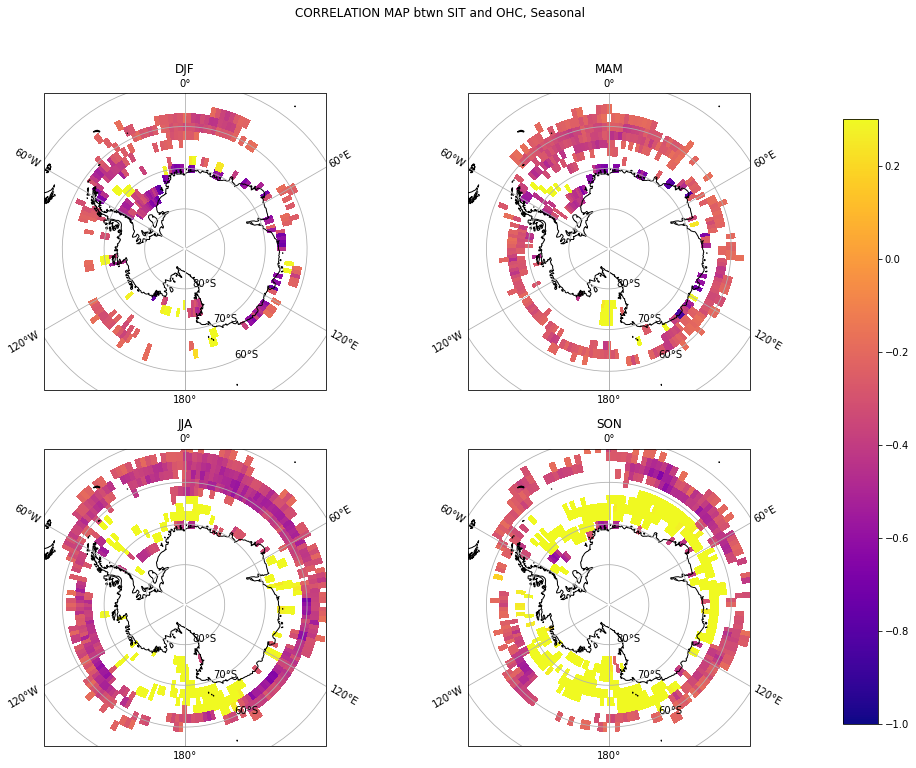

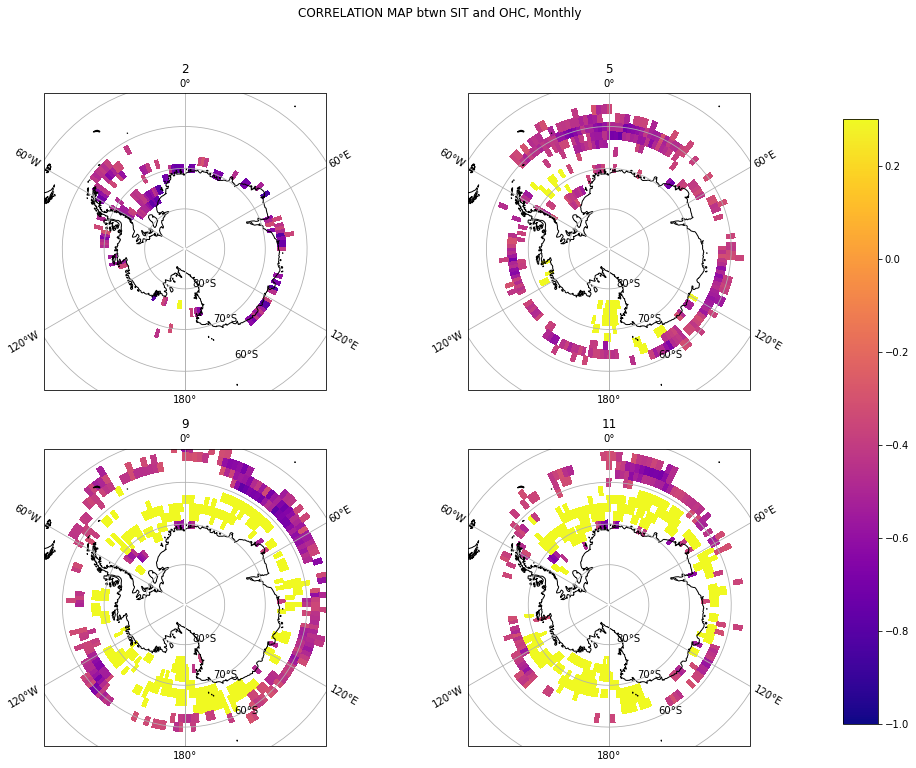

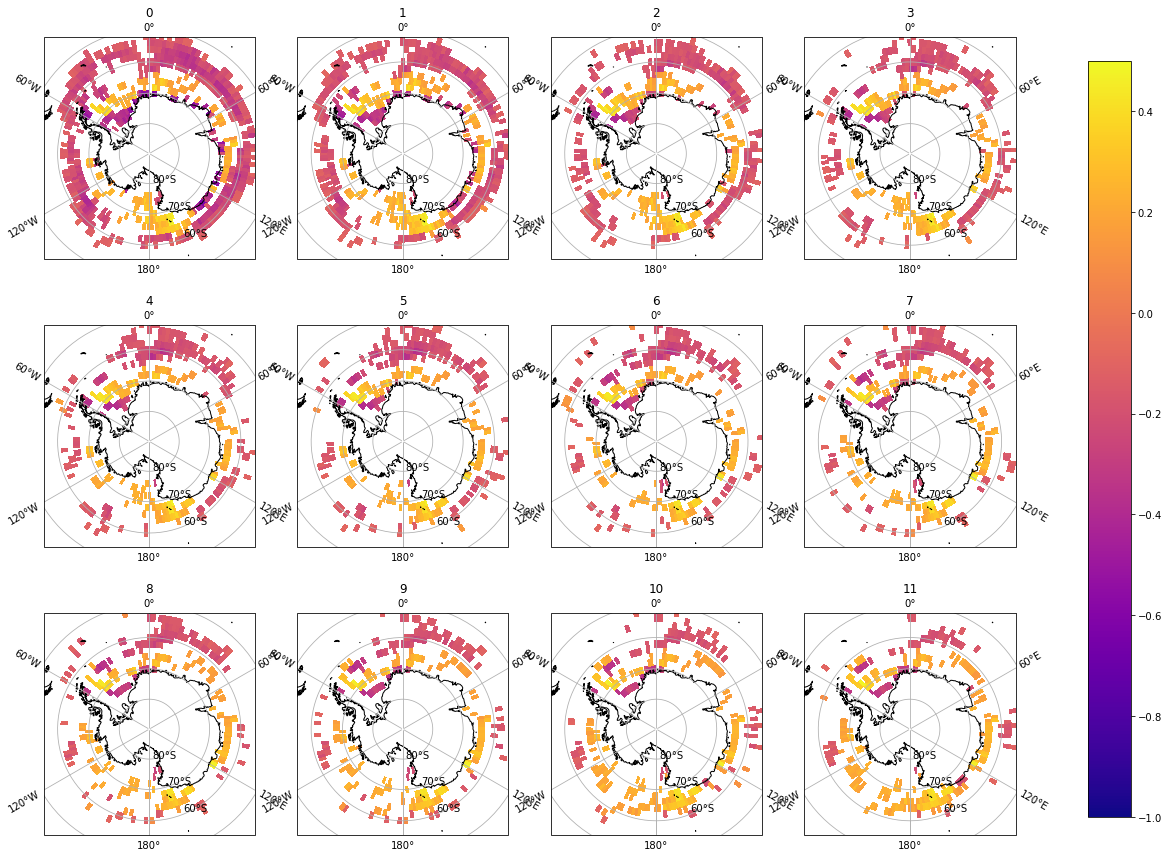

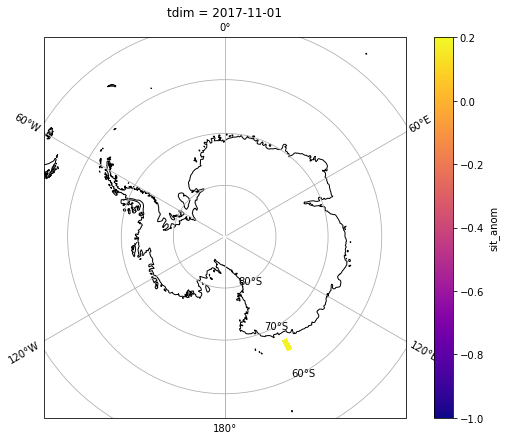

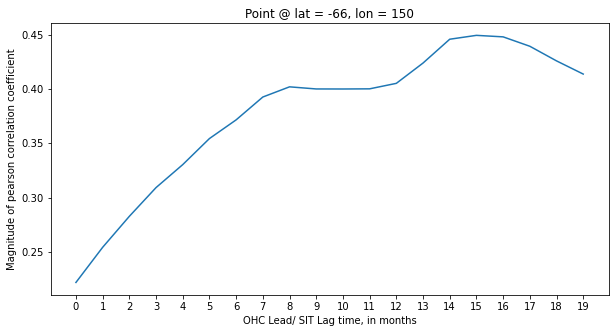

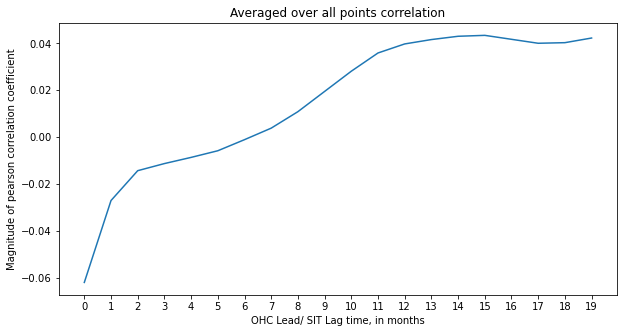

In [20]:
all_corr_plots(sit_anom, ohc_anom, "SIT", "OHC", -1, 0.3, -66, 150)

# SIT and SST comps

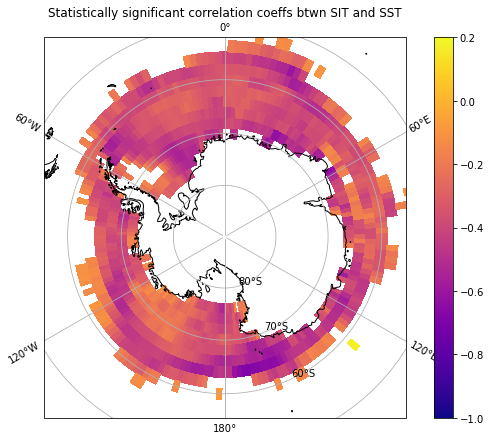

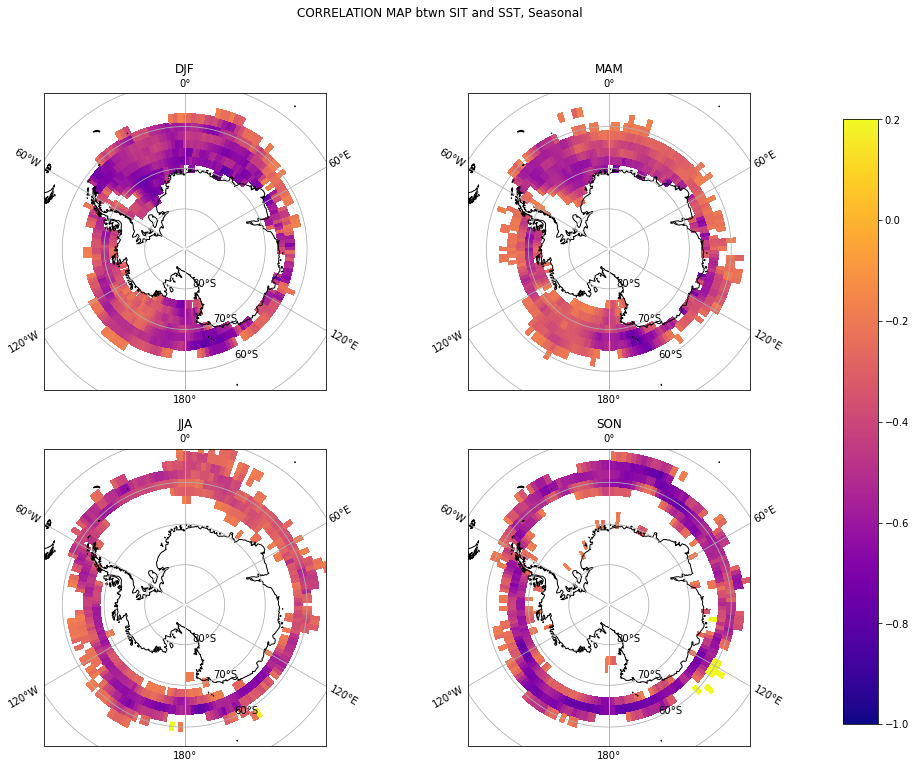

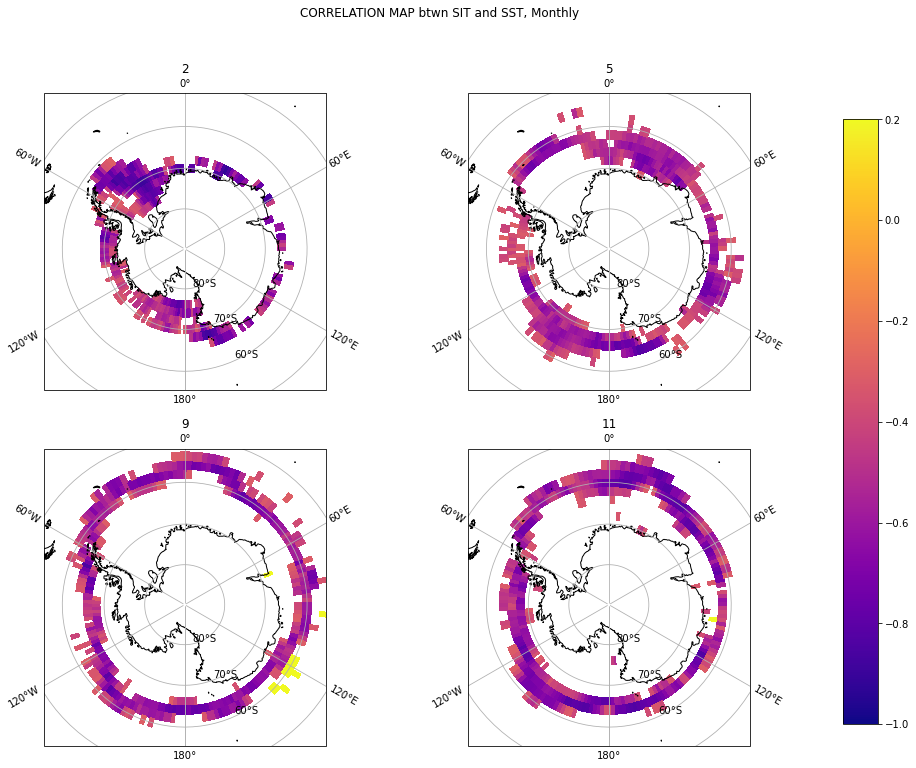

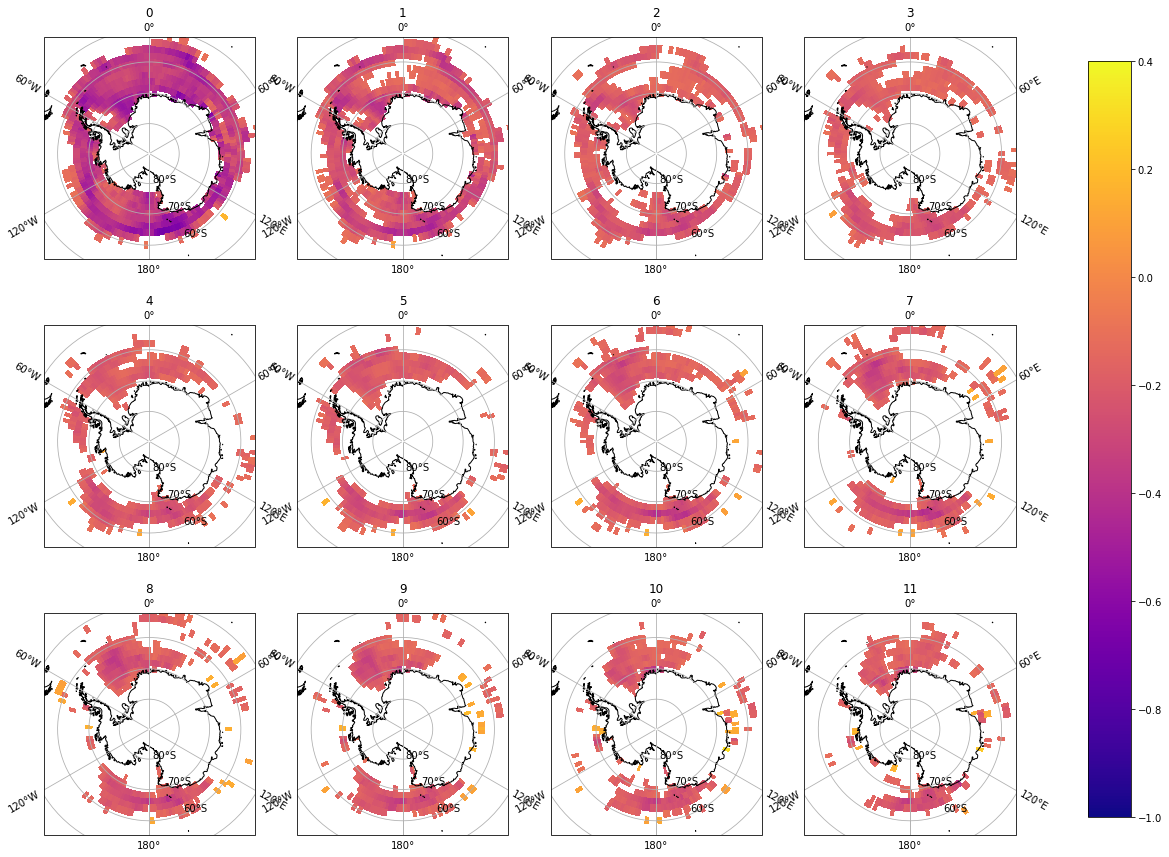

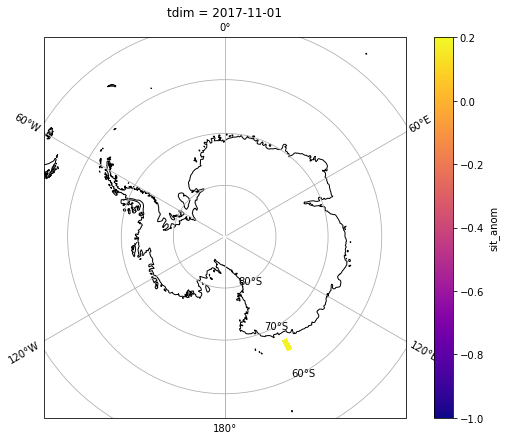

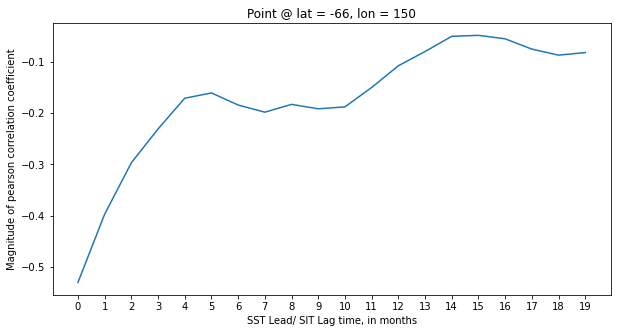

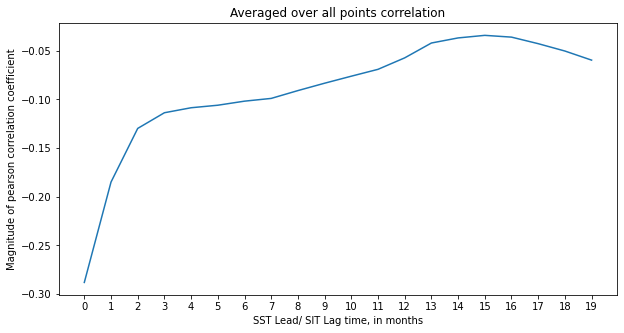

In [21]:
all_corr_plots(sit_anom, sst_anom, "SIT", "SST", -1, 0.2, -66, 150)

# Output graphs

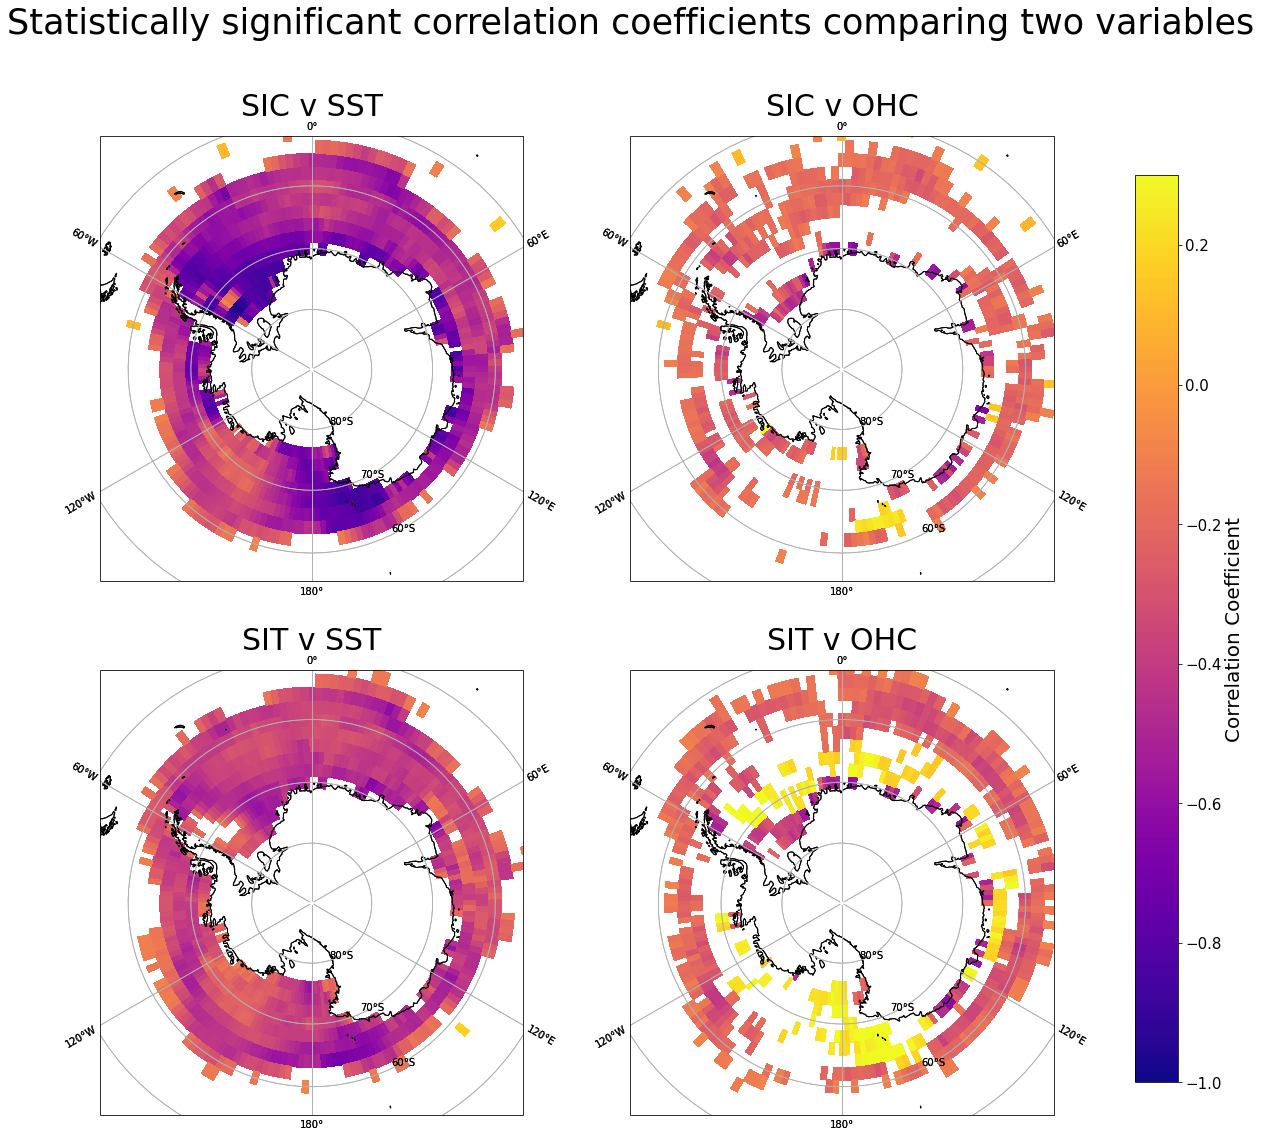

In [29]:
fig = plt.figure(figsize=(20, 18))

ax = plt.subplot(2, 2, 1, projection=sp)
#below line
plot_sig(sic_anom, sst_anom, -1, 0.3, False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title("SIC v SST", fontsize=30)


ax = plt.subplot(2, 2, 2, projection=sp)
plot_sig(sic_anom, ohc_anom, -1, 0.3, False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title("SIC v OHC", fontsize=30)

ax = plt.subplot(2, 2, 3, projection=sp)
plot_sig(sit_anom, sst_anom, -1, 0.3, False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title("SIT v SST", fontsize=30)

ax = plt.subplot(2, 2, 4, projection=sp)
im = plot_sig(sit_anom, ohc_anom, -1, 0.3, False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title("SIT v OHC", fontsize=30)

    
# Change the below line for the two variables you are comparing.
plt.suptitle("Statistically significant correlation coefficients comparing two variables", fontsize=35)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax = cbar_ax)
cbar.set_label('Correlation Coefficient', fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.show()

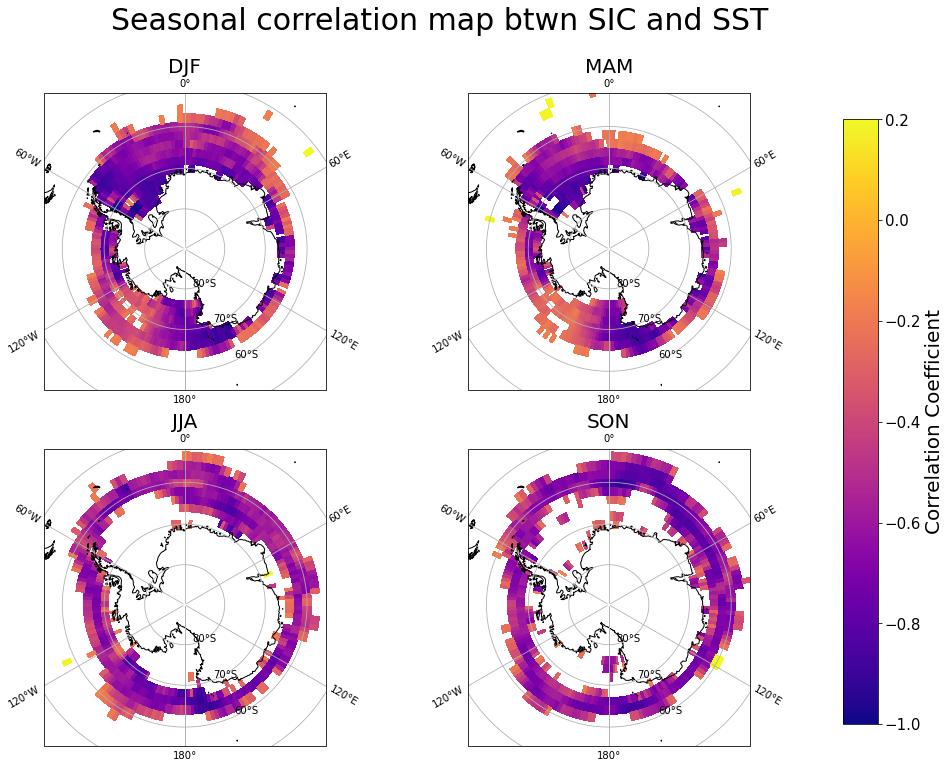

In [22]:
fig = plt.figure(figsize=(16, 12))
im = seasonal_plots(sic_anom, sst_anom, "SIC", "SST", -1, 0.2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax = cbar_ax)
cbar.set_label('Correlation Coefficient', fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.show()


#MAKE THE LABELS BIGGER.

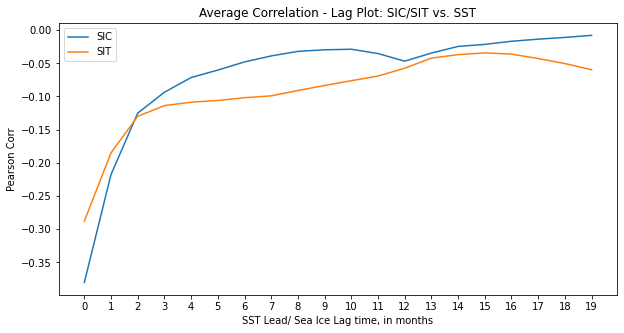

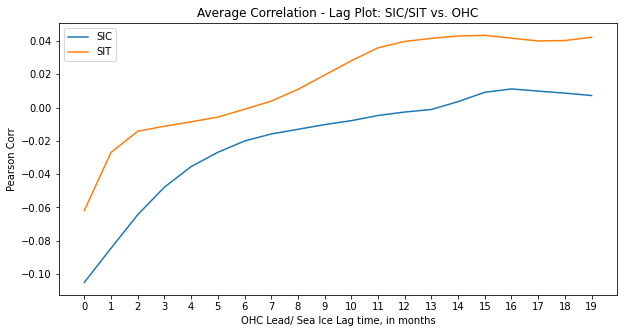

In [23]:
double_lag_plot(sst_anom, "SST")
double_lag_plot(ohc_anom, "OHC")

# SIC Anomaly plot for one point in time. just for reference

Text(0.5, 0.98, 'JUST SIC ANOMALY FOR ONE SINGLE POINT.')

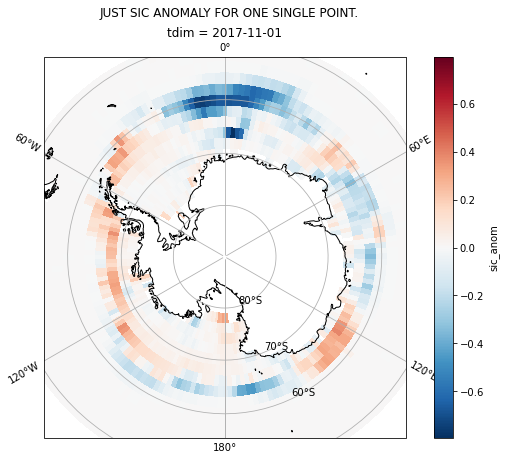

In [24]:
# this is just the sic anom for a single point. 2017-11-01 which u r very familiar with now.

arb_anom = sic_anom.sel(tdim='2017-11-01')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
#arb_time.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.suptitle('JUST SIC ANOMALY FOR ONE SINGLE POINT.')